# Lecture 2 - Surrogate modelling example
## Artificial neural networks for regression and classification

### 1 - Learning objectives 

After successfully completing this lecture, you are able to….
* Explain the fundamentals on artificial neural networks along with some of their limitations
* Explain the fundamentals on training with backpropagation
* Analyse a machine learning result in the context of overfitting
* Develop and implement neural networks in the context of basic (Bio)Chemical Engineering applications (i.e., regression and classification) 


### 2 - Setting up the environment

Opposite to Matlab, we do not have all functionalities pre installed in Python. Therefore, the first step for a project is always to install packages which extend our function library. Here, we install the following packages:
- *torch*: The PyTorch package is the most important one for this lab and inherits a variety of useful functions for machine learning.
- *matplotlib*: Provides plotting functions similar to matlab.
- *tqdm*: Allows to print progress bar of for loops
- *scikit-learn*: Machine-learning package in python, suitable for preprocessing our datasets
- *optim* is a library of optimizers for the backpropagation.

Here we use [PyTorch](https://pytorch.org/) to work with neural networks. Pytorch is an open source machine learning framework with many predefined functions which make the work with machine learning way easier. You can learn pytorch from the [tutorial link](https://pytorch.org/tutorials/). The Docs information can be searched at [Docs](https://pytorch.org/docs/stable/index.html). A popular alternative to Pytorch is Keras (building on Tensorflow). 

In [93]:
# install dependencies
!pip install torch pandas tqdm matplotlib scikit-learn seaborn

Defaulting to user installation because normal site-packages is not writeable


In [94]:
import numpy as np  # numerical calculations in python
import pandas as pd # data analysis library
import matplotlib.pyplot as plt  # plotting similar to matlab
import torch  # PyTorch: the general machine learning framework in Python
import torch.optim as optim  # contains optimizers for the backpropagation
import torch.nn as nn  # the artificial neural network module in PyTorch
from tqdm import tqdm  # produces progress bars for for-loops in Python
from sklearn.model_selection import train_test_split  # randomly splits a dataset
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler  # scaling algorithm for preprocessing
import seaborn as sns # Statistical data visualization package
import os
os.environ["CUDA_VISIBLE_DEVICES"]="" #Forces pytorch to use CPU, ensuring reproducibility

### 3- Ensuring reproducibility - Setting up the seed 

To make our results reproducible, we need to set a so-called "seed". Machine Learning includes stochastic processes in the weight/bias initialization and the backpropagation. Also the random number generation which we will use for the dataset is a stochastic process. By setting a seed in the program we make sure that always the same random numbers are chosen. Otherwise, we would get different results everytime we run this script, which is not nice for teaching purposes.

In [95]:
# Setting up a seed 

seed = 2024
torch.manual_seed(seed)                     # Sets seed for pytorch
torch.cuda.manual_seed(seed)                # Sets seed for cuda
np.random.seed(seed)                        # Sets seed for random number generator
torch.backends.cudnn.deterministic = True   # Forces cuda to use deterministic approach

In [96]:
# Loading the dataset
datafile = './FTS_exp_results_Fernandez_et_al.csv'
fts_data = pd.read_csv(datafile, sep=',', header=0)
fts_data

# In case you want to visualize the pairplots
#sns.pairplot(data=fts_data)
#plt.show()

,Run,P_{T},H_{2}:CO,U/W,X_{CO},LG,LPG,Gas,Dies,O_{2+},O_{4+},O_{9+}
0,1,1.5,2.0,1.5,46.2,0.226,0.069,0.101,0.070,0.140,0.339,0.055
1,2,1.2,0.5,1.0,44.6,0.133,0.040,0.065,0.049,0.180,0.443,0.089
2,3,1.6,1.0,1.0,62.3,0.191,0.072,0.103,0.087,0.153,0.345,0.048
3,4,2.4,2.0,1.0,68.8,0.282,0.110,0.142,0.065,0.126,0.256,0.019
4,5,1.5,2.0,1.5,47.6,0.239,0.078,0.090,0.063,0.158,0.336,0.035
5,6,3.2,1.0,1.0,64.5,0.176,0.083,0.103,0.077,0.164,0.346,0.051
6,7,3.0,0.5,1.0,48.9,0.126,0.055,0.071,0.019,0.204,0.463,0.062
7,8,2.4,2.0,0.5,80.6,0.287,0.124,0.156,0.108,0.117,0.190,0.018
8,9,2.4,2.0,2.0,52.7,0.253,0.093,0.101,0.067,0.177,0.283,0.026
9,10,2.4,2.0,1.5,61.2,0.269,0.101,0.109,0.068,0.169,0.263,0.021


### 4 - Preprocessing data 

Preprocessing the data that will be analyzed by the ANN is a crucial step. For this we need to perform the following actions: 

* We need to extract the inputs and outputs of our model from the dataset available. 
* Split the dataset into the training and test one
* Normalize our data for a better handling by the NN
* Create the tensors for the training and testing of the NN

In [97]:
# Extracting data
x_all = fts_data[["P_{T}",	"H_{2}:CO", "U/W"]].values
y_all = fts_data[["X_{CO}", "LG",	"LPG",	"Gas",	"Dies",	"O_{2+}", "O_{4+}",	"O_{9+}"]].values

# Data splitting
frac_train = 0.70  # Ratio of first splitting of dataset (15 train / 5 test)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, train_size = frac_train, random_state=seed)

# Data normalization

# Creating the normalization functions for the entries and outputs of the network
norm_entries = MinMaxScaler().fit(x_train)
norm_output = MinMaxScaler().fit(y_train)

# Implementing normalization functions to the datasets
norm_x_train = norm_entries.transform(x_train)
norm_y_train = norm_output.transform(y_train)
norm_x_test = norm_entries.transform(x_test)
norm_y_test = norm_output.transform(y_test)

# Creating the tensors for the training and test datasets
dtype = torch.float
xt_train = torch.tensor(norm_x_train, dtype=dtype).float()
xt_test = torch.tensor(norm_x_test, dtype=dtype).float()
yt_train = torch.tensor(norm_y_train, dtype=dtype).float()
yt_test = torch.tensor(norm_y_test, dtype=dtype).float()

#################################################################################
#                          END OF THE CODE                                      #
#################################################################################

### 5 - Setting up the neural network

Below you can find the setup recommended by Fernandez et al., 2006 (https://doi.org/10.1002/ceat.200500310) for the optimization of the FTS process. 

Now with the tensors being properly defined, we can build and train the FFNN for predicting the product distribution from FTS at 523 K. Fernandes et al., 2006 suggested that a topology of 20-25-25 for three hidden layers was suitable. Thus, we will give it a try. You can tune the number of nodes per layer, the number of hidden layers, and the learning rate. In order to assess the accuracy of your model, we calculate the MSE for the test set during training and testing. 

In this task, you invite you to tune the following variables and explore the results upon the change:

* `n_input`, `n_output`, `n_nodes` and `epochs` used for your FF-NN.

In [98]:
# Defining the neural network class for this problem

class NeuralNetwork(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):

        ''' Sets up the layout of the neural network.  
        
        n_iput: number of input neurons
        n_hidden: number of neurons in the hidden layers
        n_output: number of output neurons

        '''
        # Unpacking topology

        n_hidden1, n_hidden2, n_hidden3 = n_hidden      #unpacking topology of layers

        super(NeuralNetwork, self).__init__()
        self.architecture = nn.Sequential(
            # sequential model definition: add up layers & activation functions
            nn.Linear(in_features=n_input, out_features=n_hidden1, bias=True),  # input layer
            nn.ReLU(), # activation function
            
            # First hidden layer

            nn.Linear(in_features=n_hidden1, out_features=n_hidden2, bias=True),  # hidden layer
            nn.ReLU(), # activation function of hidden layer

            # Second hidden layer

            nn.Linear(in_features=n_hidden2, out_features=n_hidden3, bias=True),  # hidden layer
            nn.ReLU(), # activation function of hidden layer

        # Third hidden layer

            nn.Linear(in_features=n_hidden3, out_features=n_output, bias=True),  # hidden layer
            nn.ReLU(), # activation function of hidden layer

            # Output layer
            nn.Linear(in_features=n_output, out_features=n_output, bias=True),   # output layer

        )
    def forward(self, input): # feed forward path
        output = self.architecture(input)
        return output

hidden_size = [20, 25, 25] # number of neurons in h1, h2, h3
learning_rate = 0.5e-3

# neural network training
net = NeuralNetwork(3, hidden_size, 8) # create instance of neural network (inputs, hidden layer topology, outputs)
optimizer = optim.Adam(net.parameters(), lr=learning_rate) # choose optimizer and learning rate
loss_fun = nn.MSELoss() # define loss function
epochs = 150000 # set number of epochs
net             # prints the network topology


NeuralNetwork(
  (architecture): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=8, bias=True)
  )
)

### 6 - Training the network 

100%|██████████| 150000/150000 [01:40<00:00, 1489.20it/s]


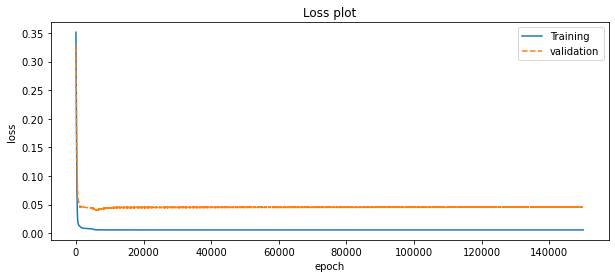

Final training loss: 
0.005832319147884846
Hidden layer size:  [20, 25, 25]
Learning rate:  0.0005
Validation MSE: 0.05


In [99]:
# Training

# Lists to store the loss values during training and testing
train_loss = []
val_loss = []

# train the network
for epoch in tqdm(range(epochs)):

    # training data
    optimizer.zero_grad() # clear gradients for next training epoch
    y_pred = net(xt_train) # forward pass: prediction y based on input x
    loss = loss_fun(y_pred, yt_train)  # compare true y and predicted y to get the loss
    loss.backward() # backpropagation, compute gradients
    optimizer.step() # apply gradients to update weights and biases
    train_loss.append(loss.item()) # save loss for later evaluation

    # validation data
    y_val = net(xt_test) # prediction of y based on input from validation set
    loss = loss_fun(y_val, yt_test) # compare true y and predicted y to get the loss
    val_loss.append(loss.item()) # save loss for later evaluation

# Training and validation graph

plt.figure(figsize=(10,4))
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='validation', linestyle='--')
#plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss plot')
plt.show()
print('Final training loss: ')
print(train_loss[-1])

# Summary

print('Hidden layer size: ', hidden_size)
print('Learning rate: ', learning_rate)
print('Validation MSE: {:.2f}'.format(val_loss[-1])) # last element from the validation loss

#################################################################################
#                          END OF THE CODE                                      #
#################################################################################

### 7 - Assessing our predictions 

Fernandes et al., assessed the predictions from the NN by using the absolute and relative errors of the product distribution (i.e., OPE and MPE, respectively). 
Additionally, after training their model, they suggest some optimal conditions for obtaining the maximum yields of gasoline, Diesel, and Diesel with olefins with C9+ molecules. For our puposes, first we will compare the prediction with the results obtained for the first run reported in Table 1 (Fernandes et al., 2006). 

* ***Presure [MPa]*** : 1.5
* ***$H_{2}$:$CO$ ratio [-]*** : 2.0
* ***$\phi$/W [$10^{3}$ N $m^{3}$ $g_{{cat}}^{-1}$ $s^{-1}$]***: 1.5 (i.e., space velocity)

In [140]:
# Defining functions for computing the error 

def rsme(prediction, true_result):
    return np.sqrt(((prediction - true_result)**2).mean())

def ope(prediction, true_result):
    ''' Computes the absolute error of the predictions '''

    return np.sum(np.abs(prediction - true_result))

def mpe(prediction, true_result):
    ''' Relative error [%] according to Fernandes et al., 2006 '''

    return np.sum(np.abs(prediction - true_result)/true_result)/np.size(true_result)*100

# Comparison of the prediction and ground truth values for the 1st run in Fernandes et al., 2006
op_conditions = np.array([1.5, 2.0, 1.5]).reshape(-1,1)

# Normalization of operational conditions
norm_op_conditions = norm_entries.transform(op_conditions.T)  # The normalized entries

# Converting operational conditions to tensor
xt_op = torch.tensor(norm_op_conditions, dtype=torch.float)

# Predicting product distribution with NN
with torch.no_grad():
    sol = net(xt_op)

# Extracting the prediction
prediction = sol.detach().numpy()
rescaled_prediction = norm_output.inverse_transform(prediction) # Rescaling the output

# Result suggested by Fernandes et al., 2006
# Order: xco, LG, LPG, Gasoline, Diesel, O2+, O4+, O9+
expected_result = np.array(([46.2, 0.226, 0.069, 0.101, 0.070, 0.140, 0.339, 0.055]))

# Calculating the RSME of the prediction
error = rsme(rescaled_prediction, expected_result)

#Calculating the MPE and OPE according to the definitions of Fernandes et al., 2006
error_mpe = mpe(rescaled_prediction, expected_result)
error_ope = ope(rescaled_prediction, expected_result)

# Printing the results 
print('The operating conditions : \n \
      Pressure: {:.2f} MPa \n \
      H2:CO ratio: {:.2f}  \n \
      Space velocity: {:.2f} \n \
      result in the following values for: \n \
       - OPE: {:.2f} \n \
       - MPE {:.2f} %'.format(op_conditions[0,0], 
                              op_conditions[1,0], 
                              op_conditions[2,0], 
                               error_ope, error_mpe))



The operating conditions : 
       Pressure: 1.50 MPa 
       H2:CO ratio: 2.00  
       Space velocity: 1.50 
       result in the following values for: 
        - OPE: 5.74 
        - MPE 16.53 %


Additionally, after training their model, they suggest some optimal conditions for obtaining the maximum yields of gasoline, Diesel, and Diesel with olefins with C9+ molecules. For our puposes, we will test the conditions they reported for maximizing the yield of gasoline: 

* ***Presure [MPa]*** : 2.51
* ***$H_{2}$:$CO$ ratio [-]*** : 1.75
* ***$\phi$/W [$10^{3}$ N $m^{3}$ $g_{{cat}}^{-1}$ $s^{-1}$]***: 0.50 (i.e., space velocity)

In [141]:
# Optimal conditions reported by Fernandes et al., 2006 (P [MPa], H2:CO ratio, phi_cat [10^3 N m3 / g_cat / s])
opt_conditions = torch.tensor(np.array(([2.51, 1.75, 0.50])), dtype=torch.float).unsqueeze(-1)
opt_conditions.shape

# Normalizing the operating conditions for the NN
norm_opt_conditions = norm_entries.transform(opt_conditions.T)  # The normalized entries

# Creates the tensor of the optimal conditions
xt_opt = torch.tensor(norm_opt_conditions, dtype=torch.float)

# Implementing the network to predict product distribution
with torch.no_grad():
    sol = net(xt_opt)

# Extracting the prediction and rescale it 
prediction = sol.detach().numpy()
rescaled_prediction = norm_output.inverse_transform(prediction)

# Post-processing the prediction according to the variables reported by Fernandes et al., 2006
# i.e., olefins O2+ and O4+ are combined 
opt_prediction = np.append(rescaled_prediction[0,:4], 
                                [rescaled_prediction[0,5]+ rescaled_prediction[0,6],
                                rescaled_prediction[0,7]])

# Results for the optimum conditions for producing gasoline according to Fernandes et al., 2006
# i.e., Xco, LG, LPG, Gasoline, Diesel, O2+ + O4+ , O9+
expected_result = np.array(([80.3, 0.287, 0.124, 0.156, 0.308, 0.017])) 

# Calculating OPE
error_ope = ope(opt_prediction, expected_result)

# Calculating MPE
error_mpe = mpe(opt_prediction, expected_result)

# Printing the results 
print('The operating conditions : \n \
      Pressure: {:.2f} MPa \n \
      H2:CO ratio: {:.2f}  \n \
      Space velocity: {:.2f} \n \
      result in the following values for: \n \
       - OPE: {:.2f} \n \
       - MPE {:.2f} %'.format(op_conditions[0,0], 
                              op_conditions[1,0], 
                              op_conditions[2,0], 
                               error_ope, error_mpe))

The operating conditions : 
       Pressure: 1.50 MPa 
       H2:CO ratio: 2.00  
       Space velocity: 1.50 
       result in the following values for: 
        - OPE: 3.81 
        - MPE 1.61 %


### 8 - Summary

We showed how a simple NN can be set and how it can be implemented to derive a model for predicting the product distribution of a FTS conducted at 523 K. The results are close to the reported ones, but for the last fraction of olefins (O9+). This indicates that the topology require a fine-tunning of the hyperparameters. 
